In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


In [4]:
# Root directory for dataset
dataroot1 = r"C:\Users\dlons1\Downloads\archive\OCTUCSD-3class\OCTUCSD-3class\OCT\train\DRUSEN"
dataroot2 = r"C:\Users\dlons1\Downloads\archive\OCTUCSD-3class\OCTUCSD-3class\OCT\train\CNV"
dataroot3 = r"C:\Users\dlons1\Downloads\archive\OCTUCSD-3class\OCTUCSD-3class\OCT\train\NORMAL"


# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
import cv2

def preprocess_oct_image(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert white pixels to black
    img[img == 255] = 0


    ## Random spin of the image
    angle = random.randint(0, 360)  # Generate random angle between 0 and 360 degrees
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)  # Get rotation matrix
    img = cv2.warpAffine(img, M, (cols, rows))  # Apply rotation

    # Optional: Normalize the image
    cleaned_image = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Convert white pixels to black again (in case normalization created new white pixels)
    cleaned_image[cleaned_image == 255] = 0

    return cleaned_image

def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Check if input directory exists
    if not os.path.exists(input_dir):
        print(f"Error: Input directory '{input_dir}' does not exist")
        return

    # Get all image files from input directory
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Print debugging information
    print(f"Looking for images in: {input_dir}")
    print(f"Found files: {os.listdir(input_dir)}")
    print(f"Found image files: {image_files}")

    for image_file in image_files:
        # Construct full input and output paths
        input_path = os.path.join(input_dir, image_file)
        output_path = os.path.join(output_dir, f"processed_{image_file}")

        # Process and save each image
        processed = preprocess_oct_image(input_path)
        cv2.imwrite(output_path, processed)

    print(f"Processed {len(image_files)} images")



# Example usage
input_directory1 = dataroot1
input_directory2 = dataroot2
input_directory3 = dataroot3

output_directory = "./content/OCTUCSD-3class/OCTUCSD-3class/OCT/trainFix/TRAIN"
process_dataset(input_directory1, output_directory)
process_dataset(input_directory2, output_directory)
process_dataset(input_directory3, output_directory)

Looking for images in: C:\Users\dlons1\Downloads\archive\OCTUCSD-3class\OCTUCSD-3class\OCT\train\DRUSEN
Found files: ['DRUSEN-1001666-1.jpeg', 'DRUSEN-1001666-2.jpeg', 'DRUSEN-1001666-3.jpeg', 'DRUSEN-1001666-4.jpeg', 'DRUSEN-1001666-5.jpeg', 'DRUSEN-1001666-6.jpeg', 'DRUSEN-1001666-7.jpeg', 'DRUSEN-1001666-8.jpeg', 'DRUSEN-1001666-9.jpeg', 'DRUSEN-1001772-1.jpeg', 'DRUSEN-1001772-2.jpeg', 'DRUSEN-100580-1.jpeg', 'DRUSEN-1016042-1.jpeg', 'DRUSEN-1016042-2.jpeg', 'DRUSEN-1016042-3.jpeg', 'DRUSEN-1016042-4.jpeg', 'DRUSEN-1016042-5.jpeg', 'DRUSEN-1016042-6.jpeg', 'DRUSEN-1016042-7.jpeg', 'DRUSEN-1020679-1.jpeg', 'DRUSEN-1020679-2.jpeg', 'DRUSEN-1020679-3.jpeg', 'DRUSEN-1020679-4.jpeg', 'DRUSEN-1020679-5.jpeg', 'DRUSEN-1021530-1.jpeg', 'DRUSEN-1021530-2.jpeg', 'DRUSEN-103885-1.jpeg', 'DRUSEN-103885-2.jpeg', 'DRUSEN-103885-3.jpeg', 'DRUSEN-103885-4.jpeg', 'DRUSEN-103885-5.jpeg', 'DRUSEN-1042462-1.jpeg', 'DRUSEN-1046294-1.jpeg', 'DRUSEN-1046294-2.jpeg', 'DRUSEN-1046294-3.jpeg', 'DRUSEN-10462

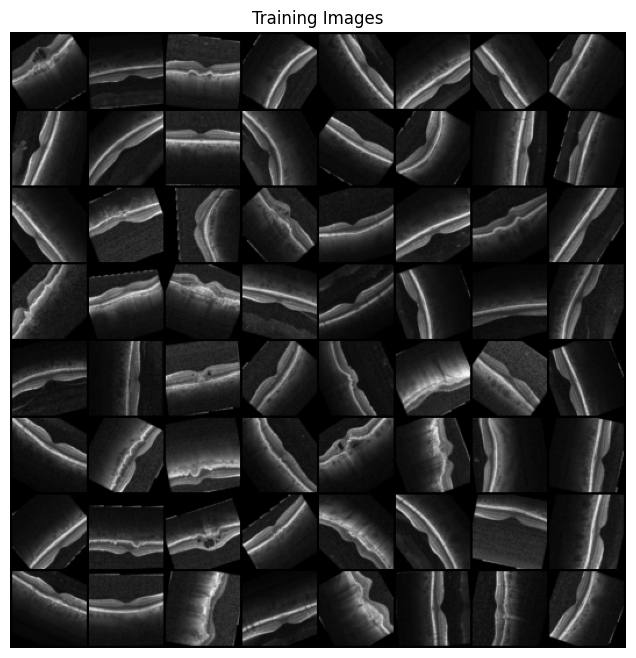

In [6]:

# Data set to be used for training 
dataroot = "./content/OCTUCSD-3class/OCTUCSD-3class/OCT/trainFix"

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,
                                         pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)



# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generator(
  (main): Sequentia

In [10]:
# Initialize the ``BCELoss`` function
criterion = nn.BCEwithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


# Enable automatic mixed precision training
scaler = torch.cuda.amp.GradScaler()


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad(set_to_none=True)


        # Format batch
        real_cpu = data[0].to(device, non_blocking=True)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Enable autocast for mixed precision training
        with torch.autocast(device.type, dtype=torch.bfloat16):
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
        
        
        # Calculate gradients for D in backward pass
        scaler.scale(errD_real).backward()
        D_x = output.mean().item()



        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)



        with torch.cuda.amp.autocast():
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        scaler.scale(errD_fake).backward()


        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        scaler.step(optimizerD)





        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad(set_to_none=True)


        label.fill_(real_label)  # fake labels are real for generator cost


        with torch.cuda.amp.autocast():
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            
            
        # Calculate gradients for G
        scaler.scale(errG).backward()
        D_G_z2 = output.mean().item()
        # Update G
        scaler.step(optimizerG)


        scaler.update()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

C:\Users\dlons1\AppData\Local\Temp\ipykernel_20264\3714644816.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Training Loop...


RuntimeError: torch.nn.functional.binary_cross_entropy and torch.nn.BCELoss are unsafe to autocast.
Many models use a sigmoid layer right before the binary cross entropy layer.
In this case, combine the two layers using torch.nn.functional.binary_cross_entropy_with_logits
or torch.nn.BCEWithLogitsLoss.  binary_cross_entropy_with_logits and BCEWithLogits are
safe to autocast.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:

# Add code to save generated images
# Create directory for saving images if it doesn't exist
os.makedirs('generated_images', exist_ok=True)

# Save the final grid of fake images
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Final Fake Images Grid")
grid_img = np.transpose(img_list[-1],(1,2,0))
plt.imshow(grid_img)
plt.savefig('generated_images/final_grid.png', bbox_inches='tight', pad_inches=0)
plt.close()

# Generate and save individual fake images
print("Generating and saving individual fake images...")
with torch.no_grad():
    # Generate a batch of fake images
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()
    
    # Save individual images
    for idx in range(fake_images.size(0)):
        vutils.save_image(fake_images[idx], 
                         f'generated_images/fake_image_{idx+1}.png',
                         normalize=True)

print(f"Images saved in the 'generated_images' directory")

# Save the trained model
torch.save({
    'generator_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
}, 'gan_model.pth')

print("Model saved as 'gan_model.pth'")